# Image Segmentation with U-Net

<a name='1'></a>
## 1 - Packages

Importing all required packages.

In [2]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

from test_utils import summary, comparator

<a name='1'></a>
## 2 - Load and split data

In [7]:
import os
import numpy as np
import pandas as pd 

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [8]:
len(image_list)

1060

<a name='1'></a>
### Checking out the some of the unmasked and masked images from the dataset:

C:\Users\atulj\AppData\Local\Temp\ipykernel_11652\3468410390.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
C:\Users\atulj\AppData\Local\Temp\ipykernel_11652\3468410390.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

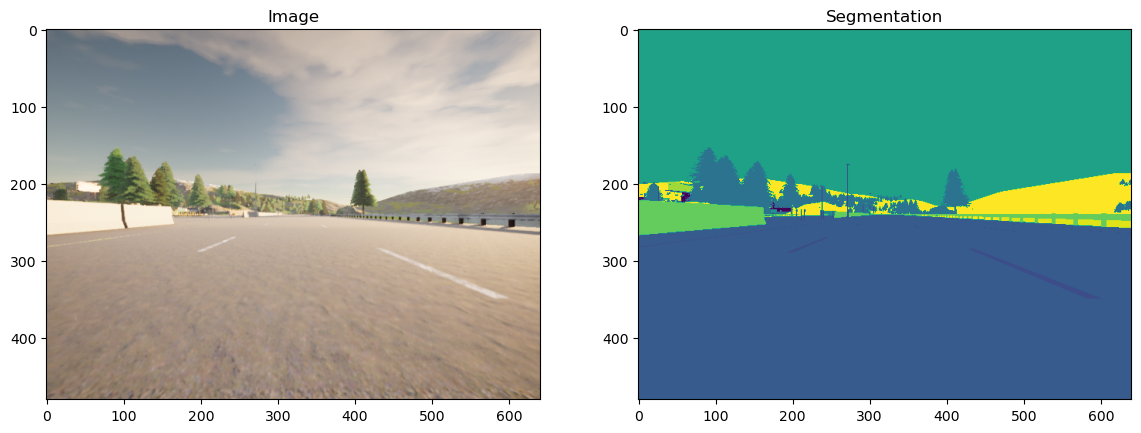

In [9]:
N = 3
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

<a name='1'></a>
### 2.1 - Split Dataset into Unmasked and Masked Images

In [10]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\000028.png'>)


In [11]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./data/CameraRGB/000026.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraMask/000026.png', shape=(), dtype=string)


<a name='1'></a>
### 2.2 - Preprocess Data

In [12]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    input_image = input_image / 255.

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)<a name='1'></a>
### 2.1 - Split Your Dataset into Unmasked and Masked Images

<a name='1'></a>
## 3 - U-Net

### 3.2 - Encoder (Downsampling Block)

In [13]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters,
                  3,
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(inputs)
    conv = Conv2D(n_filters,
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    
    
    if dropout_prob > 0:
       
        conv = Dropout(dropout_prob)(conv)
        
         
        
  
    if max_pooling:
       
        next_layer = MaxPooling2D(2,strides=2)(conv)
      
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

### 3.3 - Decoder (Upsampling Block)

In [14]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    
    up = Conv2DTranspose(
                 n_filters,  
                 3,
                 strides=2,
                 padding='same')(expansive_input)
    
    
    merge = concatenate([up, contractive_input], axis=3)
    
    conv = Conv2D(n_filters, 
                  3,   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(merge)
    conv = Conv2D(n_filters, 
                  3,
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
   
    
    return conv

### 3.4 - Build the Model

In [15]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)
    
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3)
    
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False) 
    
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
     
    
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)
    

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

   
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

### 3.5 - Set Model Dimensions

In [16]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

### Model Summary

In [17]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 128, 3)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 96, 128, 32)          896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 96, 128, 32)          9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 48, 64, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

 conv2d_19 (Conv2D)          (None, 96, 128, 23)          759       ['conv2d_18[0][0]']           
                                                                                                  
Total params: 8640471 (32.96 MB)
Trainable params: 8640471 (32.96 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________


### 3.6 - Loss Function

In [18]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 3.7 - Dataset Handling

In [19]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(480, 640, 1)


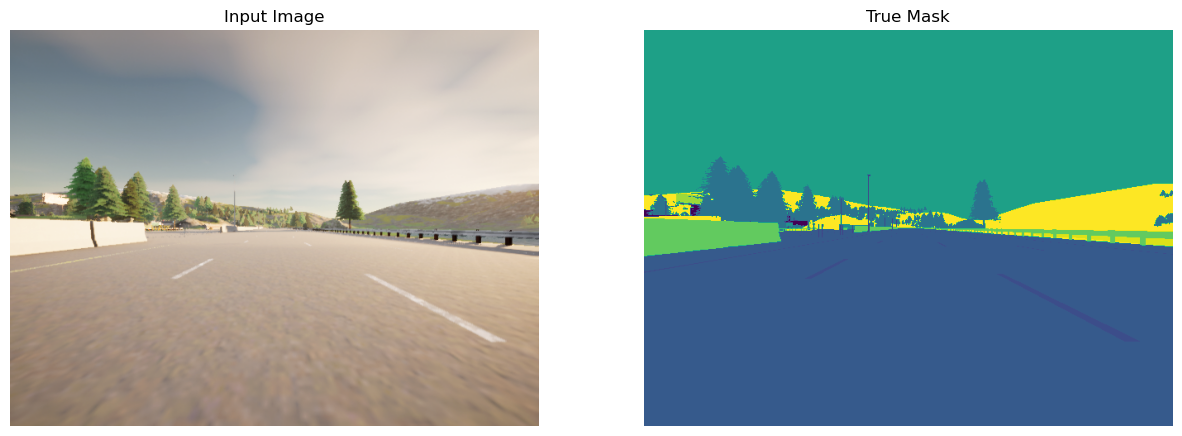

In [20]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


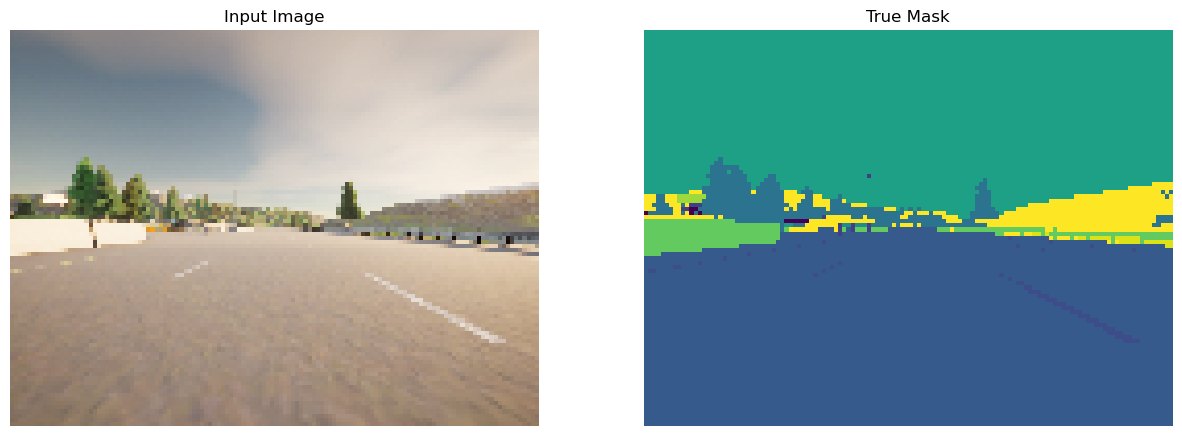

In [21]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

<a name='1'></a>
## 4 - Train the Model

In [28]:
EPOCHS = 20
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/20
34/34 [==============================] - 82s 2s/step - loss: 0.6313 - accuracy: 0.8041
Epoch 2/20
34/34 [==============================] - 79s 2s/step - loss: 0.5719 - accuracy: 0.8168
Epoch 3/20
34/34 [==============================] - 83s 2s/step - loss: 0.5380 - accuracy: 0.8249
Epoch 4/20
34/34 [==============================] - 82s 2s/step - loss: 0.8406 - accuracy: 0.7783
Epoch 5/20
34/34 [==============================] - 83s 2s/step - loss: 0.7631 - accuracy: 0.7764
Epoch 6/20
34/34 [==============================] - 82s 2s/step - loss: 0.6251 - accuracy: 0.7981
Epoch 7/20
34/34 [==============================] - 82s 2s/step - loss: 0.5683 - accuracy: 0.8126
Epoch 8/20
34/34 [==============================] - 87s 3s/step - loss: 0.5811 - accuracy: 0.8086
Epoch 9/20
34/34 [==============================] - 82s 2s/step - loss: 0.5360 - accuracy: 0.82

### 4.1 - Create Predicted Masks

In [29]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

<a name='1'></a>
### 4.2 - Plot Model Accuracy

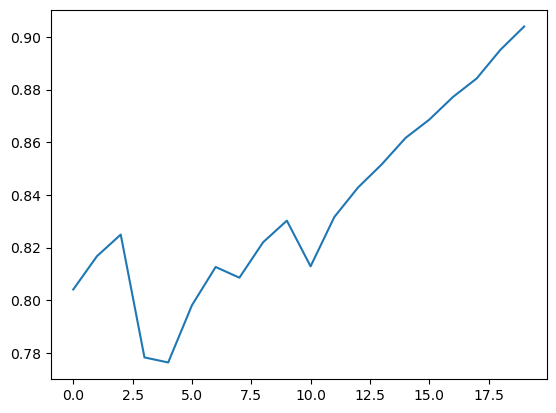

In [30]:
plt.plot(model_history.history["accuracy"])

<a name='1'></a>
### 4.3 - Show Predictions

In [31]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 409ms/step


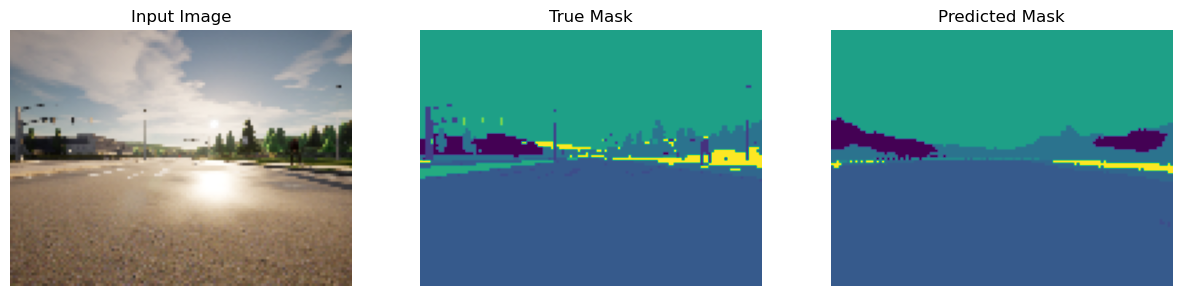

1/1 [==============================] - 0s 399ms/step


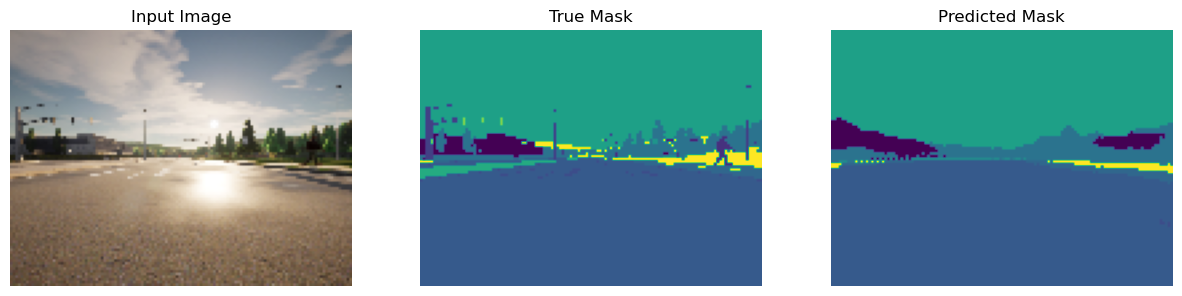

1/1 [==============================] - 0s 389ms/step


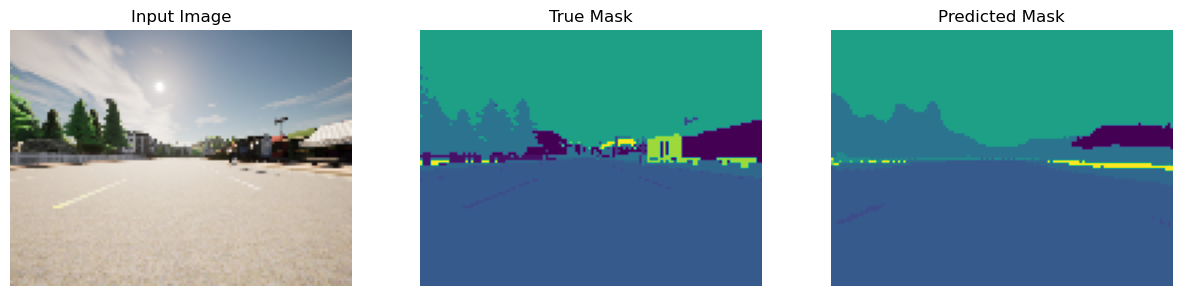

1/1 [==============================] - 0s 392ms/step


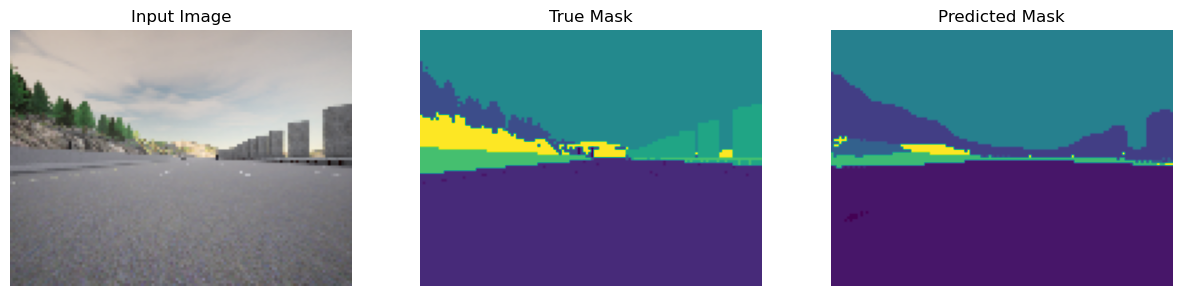

1/1 [==============================] - 0s 398ms/step


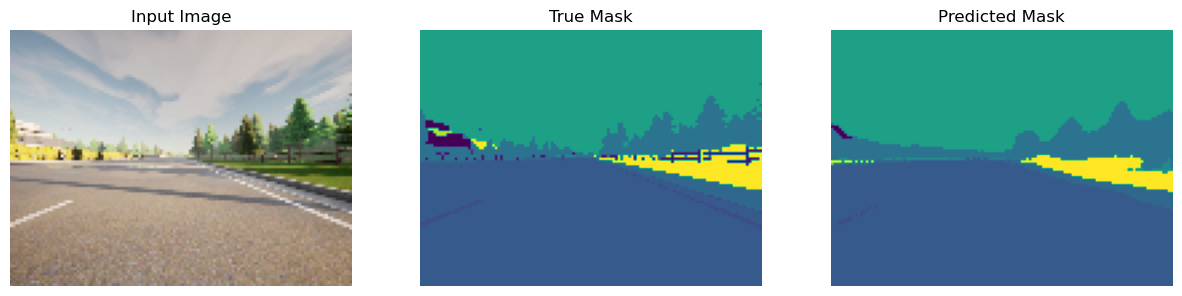

1/1 [==============================] - 0s 390ms/step


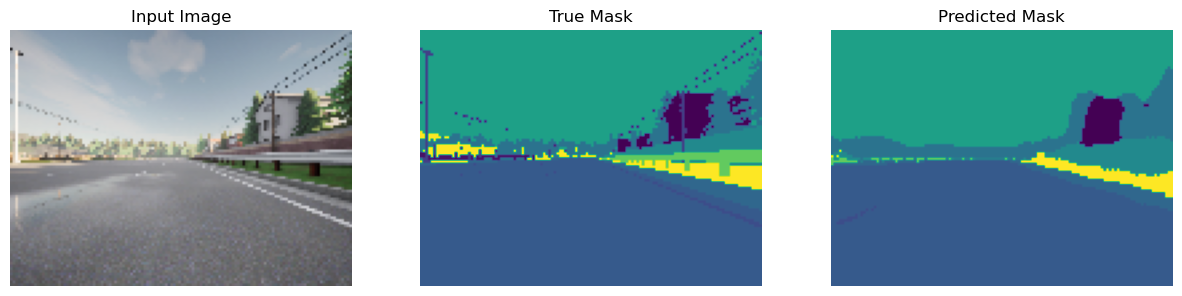

In [32]:
show_predictions(train_dataset, 6)